In [1]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
# !apt-get update > /dev/null 2>&1
# !apt-get install cmake > /dev/null 2>&1
# !pip install --upgrade setuptools 2>&1
# !pip install ez_setup > /dev/null 2>&1
# !pip install gym[atari] > /dev/null 2>&1

In [3]:
# adapted from: https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/Deep_Q_Network_Solution.ipynb

import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# adapted from: https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/model.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [5]:
# adapted from: https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/dqn_agent.py

import numpy as np
import random
from collections import namedtuple, deque

# from model import QNetwork

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [7]:
env = gym.make('MountainCar-v0')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (2,)
Number of actions:  3


In [9]:
agent = Agent(state_size=2, action_size=2, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

In [10]:

def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

Episode 100	Average Score: -200.00
Episode 200	Average Score: -200.00
Episode 300	Average Score: -200.00
Episode 400	Average Score: -200.00
Episode 500	Average Score: -200.00
Episode 545	Average Score: -200.00

KeyboardInterrupt: 

In [6]:
def get_brain_state(agent):
    return np.random.uniform(size=(5, 10))

print(get_brain_state(agent))

[[0.05905001 0.53176623 0.1304486  0.96038455 0.63012742 0.5545182
  0.90878762 0.2552461  0.42492424 0.06290088]
 [0.47423882 0.53972919 0.45880025 0.52223156 0.85956767 0.42173886
  0.77414145 0.7074582  0.56329612 0.79013357]
 [0.8708825  0.82602656 0.39420978 0.83051161 0.69142535 0.18106311
  0.27634156 0.85222085 0.17263864 0.57389748]
 [0.8958149  0.73294267 0.36542551 0.59314215 0.72719728 0.85350596
  0.02934862 0.05981326 0.00177935 0.24679431]
 [0.79643284 0.34267838 0.94611307 0.13262977 0.18596086 0.68382453
  0.33243761 0.39095377 0.37519876 0.03753847]]


In [7]:
def get_self_reported_mental_state(agent):
    return ["I believe I'm falling to fast",
            "I desire to land",
            "I desire to move more to the left"]

print(get_self_reported_mental_state(agent))

["I believe I'm falling to fast", 'I desire to land', 'I desire to move more to the left']


In [8]:
def get_mental_state(agent):
    return np.random.uniform(0, 10, size=(1, 4)).astype(int)

print(get_mental_state(agent))

[[3 1 9 8]]


In [9]:
import PIL
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import time
from gym.wrappers import Monitor
from IPython import display
import seaborn as sns

In [15]:
env = gym.make("MountainCar-v0")
env.reset()


array([-0.58988838,  0.        ])

<IPython.core.display.Javascript object>


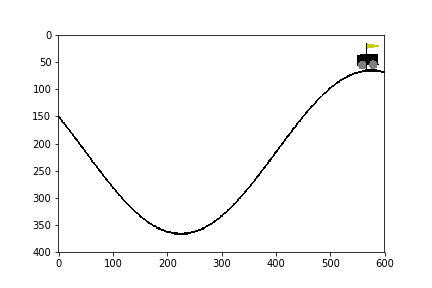

Well done!


<IPython.core.display.Javascript object>


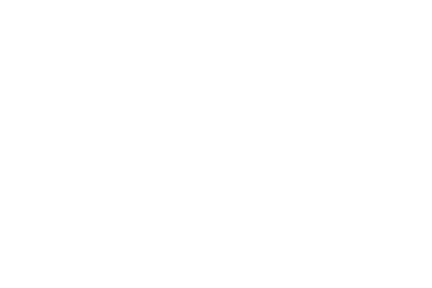

In [17]:
# create env manually to set time limit. Please don't change this.
TIME_LIMIT = 250
# env = gym.wrappers.TimeLimit(gym.envs.classic_control.MountainCarEnv(),
#                              max_episode_steps=TIME_LIMIT + 1)
s = env.reset()
actions = {'left': 0, 'stop': 1, 'right': 2}

# prepare "display"
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

def policy(t):
    if t>50 and t<100:
        return actions['left']
    else:
        return actions['right']


for t in range(TIME_LIMIT):
    
    # change the line below to reach the flag
    s, r, done, _ = env.step(policy(t))
    
    #draw game image on display
    ax.clear()
    ax.imshow(env.render('rgb_array'))
    fig.canvas.draw()
    
    if done:
        print("Well done!")
        break
else:    
    print("Time limit exceeded. Try again.")

In [10]:
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(1400, 900))
# display.start()

In [11]:
env = gym.make('LunarLander-v2')
# env = Monitor(gym.make('LunarLander-v2'), './video', force=True)
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [12]:
# from dqn_agent import Agent

agent = Agent(state_size=8, action_size=4, seed=0)

image_history = []
state_history = []
action_history = []

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    image_history.append(env.render('rgb_array'))
#     image = PIL.Image.fromarray(env.render(mode='rgb_array'))
#     imshow(image)
#     print(tmp)
    state, reward, done, _ = env.step(action)
    state_history.append(state)
    action_history.append(action)
#     print('{}, {}, {}'.format(state, action, reward), end='')

#     time.sleep(1)
#     env.close()
    
    if done:
        break 
        
env.close()

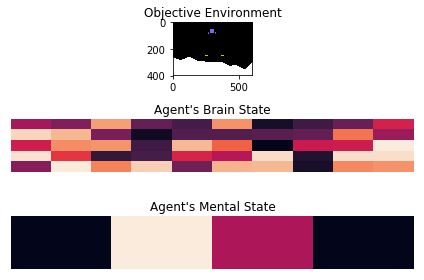


Agent's Behavioral Description:
State: [-4.4501971e-02 -4.2779543e-02  9.5820803e-07 -7.0871335e-09
  9.3380557e-05  2.9858349e-08  1.0000000e+00  1.0000000e+00]
Action:0


Agent's Self Reported Mental State:
I believe I'm falling to fast
I desire to land
I desire to move more to the left

KeyboardInterrupt: 

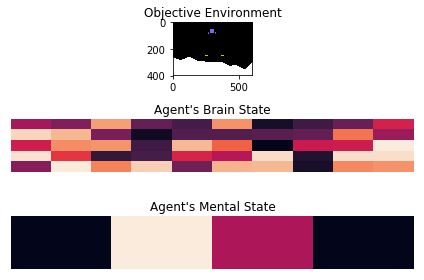

In [14]:
# plt.ion() 
# f, (ax1, ax2) = plt.subplots(1, 2)


for i, image in enumerate(image_history):
#     f.clear()
    f, (ax1, ax2, ax3) = plt.subplots(3, 1)
#     ax1.clear()
    ax1.imshow(image)
    ax1.set_title("Objective Environment")
#     ax2.clear()
    sns.heatmap(get_brain_state(agent), cbar=False, xticklabels=False, yticklabels=False, ax=ax2)
    ax2.set_title("Agent's Brain State")
    sns.heatmap(get_mental_state(agent), cbar=False, xticklabels=False, yticklabels=False, ax=ax3)
    ax3.set_title("Agent's Mental State")
    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(f)
    print()
    print("Agent's Behavioral Description:")
    print('State: {}\nAction:{}'.format(state, action), end='')
    print()
    print()
    print()
    print("Agent's Self Reported Mental State:")
    print('\n'.join(get_self_reported_mental_state(agent)), end='')
    time.sleep(2.0)
    plt.close()

In [ ]:
image_history[0].shape